# Traffic Signs Extraction and Classification Using WSLNet
**Authors: LUO Junyuan(57451737), SHI Xu(57699374), WANG Bingren(57515891)**  
Colab link: https://colab.research.google.com/drive/1jTxed8tWYCEyasf9hbtymDQc_LNIQj_J?usp=sharing  
Please run the notebook step by step, because the code blocks in the bottom rely on the upper code blocks. Thank you!

# Load Data
Import dataset from github, unpack the dataset to Traffic-Sign-Classifier.

In [ ]:
! git clone https://github.com/ChumyuenLaw/EE5811_repo.git
! mkdir 'Traffic-Sign-Classifier'
! mkdir 'Model'
! unzip -uq './EE5811_repo/test.p.zip' -d 'Traffic-Sign-Classifier'
! unzip -uq './EE5811_repo/train.p.zip' -d 'Traffic-Sign-Classifier'
! unzip -uq './EE5811_repo/valid.p.zip' -d 'Traffic-Sign-Classifier'
! unzip -uq './EE5811_repo/model_wsl_stn.pt.zip' -d 'Model'

In [ ]:
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

In [ ]:
# Load pickled data
training_file = "./Traffic-Sign-Classifier/train.p"
validation_file = "./Traffic-Sign-Classifier/valid.p"
testing_file = "./Traffic-Sign-Classifier/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# Resolution of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data resolution =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data resolution = (32, 32)
Number of classes = 43


Data visualization

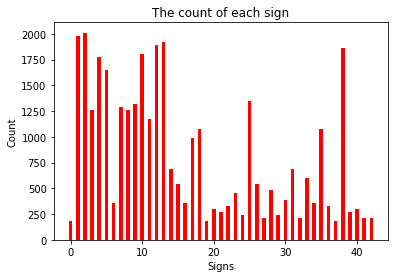

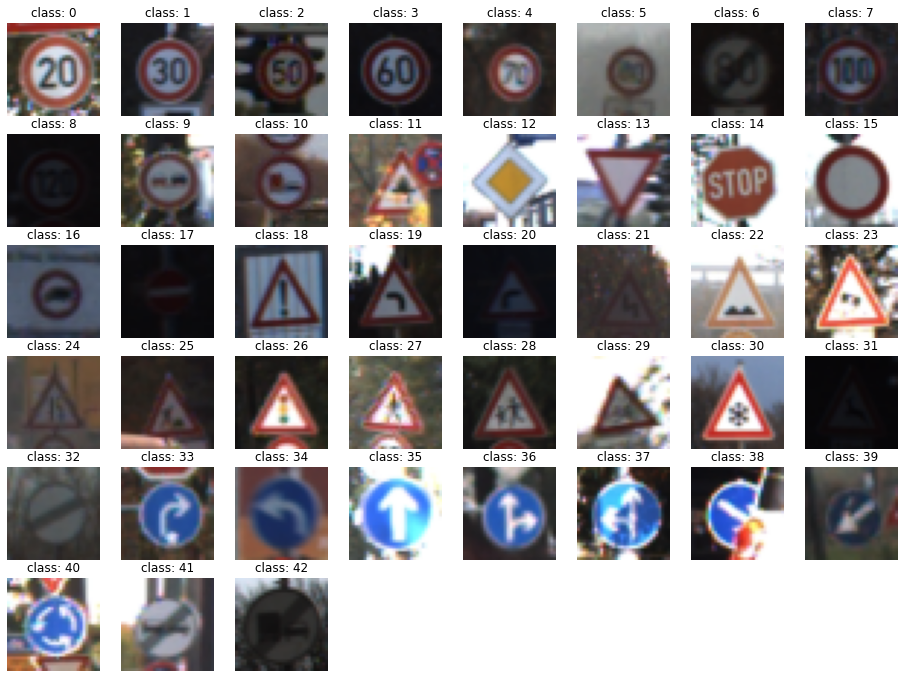

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

Load training data, valid data, and test data.

In [ ]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [ ]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [ ]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

# Grayscale Transformation and Histogram Equalization

Convert RGB to YCrCb and use the Y Component to be the grayscale output.  
Apply the Contrast-limited adaptive histogram equalization (CLAHE) algorithm to the grayscale image.

In [ ]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

Visualize the colar convertion and histogram equalization results.

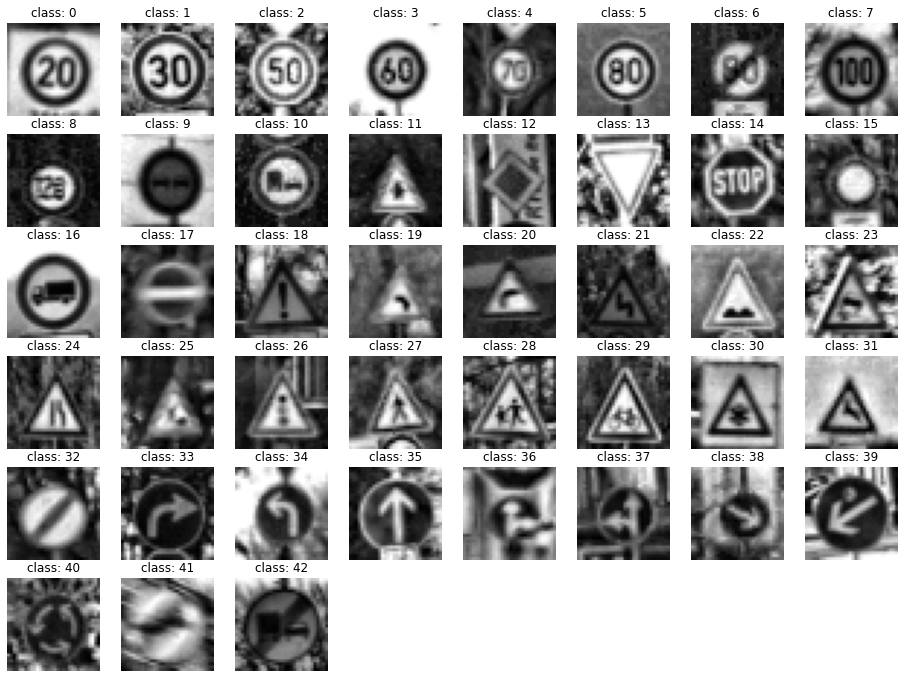

In [ ]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [ ]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=512, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=512, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=512, shuffle=False), to_device)

Save the Data to train_gray.p, test_gray.p, valid_gray.p.

In [ ]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [ ]:
preprocess('Traffic-Sign-Classifier')
training_file = 'Traffic-Sign-Classifier/train_gray.p'
validation_file = "Traffic-Sign-Classifier/valid_gray.p"
testing_file = "Traffic-Sign-Classifier/test_gray.p"

Load the data.

In [ ]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=512, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=512, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=512, shuffle=False), to_device)

# WSLNet

Wang-Shi-Luo Network (WSLNet)  
**4 Convalutional Network Layers** and **3 Fully-Connected Layers**, with **Batch Normalization Layer**, **Elu function** and **Dropout**.  


---


Network Structure:  
Input image: 32x32x1->  
Conv1: 120 5x5 -> elu -> norm_batch 120 -> maxpool 2 ->  
Conv2: 250 3x3 -> elu -> norm_batch 250 ->  
Conv3: 350 3x3 -> elu -> norm_btach 350 ->  
Conv4: 400 3x3 -> elu -> norm_batch 400 -> maxpool 2 ->  
Flatten: 400x4x4 ->  
FC1:400x4x4, 3000 ->  
FC2:3000, 500 ->  
FC3:500, 50  


## Utils
Loss function of a batch

In [ ]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

Calculate validation loss and validation accuracy of a batch.

In [ ]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

Evaluate test loss and accuracy of the model.

In [ ]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [ ]:
wsl_origin_valid_loss = []
wsl_origin_valid_acc = []
wsl_improved_dataset_valid_loss = []
wsl_improved_dataset_valid_acc = []
wsl_stn_improved_dataset_valid_loss = []
wsl_stn_improved_dataset_valid_acc = []

## WSLNet Baseline

In [ ]:
class WSLNet(nn.Module):
    def __init__(self):
        super(WSLNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 120, 5)
        self.conv1_bn = nn.BatchNorm2d(120)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(120, 250, 3)
        self.conv2_bn = nn.BatchNorm2d(250)
        self.conv3 = nn.Conv2d(250, 350, 3)
        self.conv3_bn = nn.BatchNorm2d(350)
        self.conv4 = nn.Conv2d(350, 400, 3)
        self.conv4_bn = nn.BatchNorm2d(400)
        self.fc1 = nn.Linear(4*4*400, 3000)
        self.fc1_bn = nn.BatchNorm1d(3000)
        self.fc2 = nn.Linear(3000, 500)
        self.fc2_bn = nn.BatchNorm1d(500)
        self.fc3 = nn.Linear(500, 50)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = F.elu(self.conv2(x))
        x = self.dropout(self.conv2_bn(x))
        x = F.elu(self.conv3(x))
        x = self.dropout(self.conv3_bn(x))
        x = self.pool(F.elu(self.conv4(x)))
        x = self.dropout(self.conv4_bn(x))
        x = x.view(-1, 4*4*400)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = F.elu(self.fc2(x))
        x = self.dropout(self.fc2_bn(x))
        x = self.fc3(x)
        return x

Fit function

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            wsl_origin_valid_loss.append(valid_loss)
            wsl_origin_valid_acc.append(valid_accuracy)
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'Model/model_wsl_1.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

**Train the model with parameters:**  
epochs: 100
model: WSLNet  
loss_func: nn.CrossEntropyLoss()  
optimizer: optim.Adam(model.parameters(), lr=0.0001)  
train_dl  
valid_dl  
patience: 10

In [ ]:
n_epochs = 100
model = WSLNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 1.754190	Validation loss: 0.879736	 Validation accruacy: 74.921%
Validation loss decreased (inf --> 0.879736). Saving model...
[Epoch 2/100] Train loss: 0.626160	Validation loss: 0.427626	 Validation accruacy: 88.639%
Validation loss decreased (0.879736 --> 0.427626). Saving model...
[Epoch 3/100] Train loss: 0.368950	Validation loss: 0.286353	 Validation accruacy: 92.268%
Validation loss decreased (0.427626 --> 0.286353). Saving model...
[Epoch 4/100] Train loss: 0.246343	Validation loss: 0.213312	 Validation accruacy: 94.626%
Validation loss decreased (0.286353 --> 0.213312). Saving model...
[Epoch 5/100] Train loss: 0.178891	Validation loss: 0.162271	 Validation accruacy: 95.918%
Validation loss decreased (0.213312 --> 0.162271). Saving model...
[Epoch 6/100] Train loss: 0.134206	Validation loss: 0.137189	 Validation accruacy: 96.213%
Validation loss decreased (0.162271 --> 0.137189). Saving model...
[Epoch 7/100] Train loss: 0.108785	Validation loss: 0.123

Save the model and evaluate the test loss and accuracy.

In [ ]:
check_point = torch.load('Model/model_wsl_1.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.087754	Test accruacy: 97.506%


# Dataset Improvement

## Flipping

Extend training dataset by flipping.

In [ ]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [ ]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=512, shuffle=True), to_device)

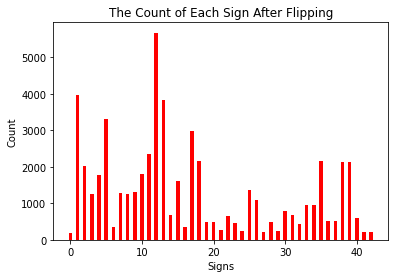

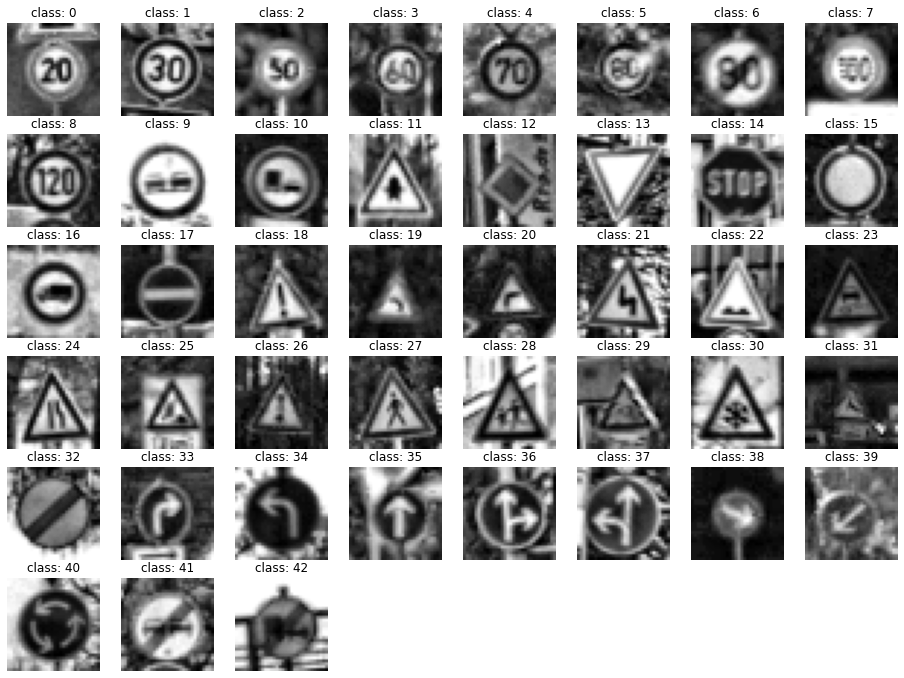

In [ ]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The Count of Each Sign After Flipping')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

## Augmentation

Extend training set by geometrically transforming(rotation, translation, shear mapping, scaling) the same sign picture.
The traning set is extended to a size of 43x4000.

In [ ]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 4000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

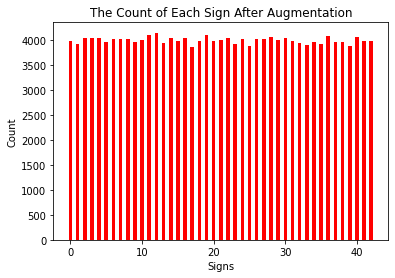

In [ ]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The Count of Each Sign After Augmentation')
plt.show()

In [ ]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, interpolation=InterpolationMode.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), interpolation=InterpolationMode.BICUBIC),
        transforms.RandomAffine(0, shear=20, interpolation=InterpolationMode.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), interpolation=InterpolationMode.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=512, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=512, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=512, shuffle=False), to_device)

In [ ]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

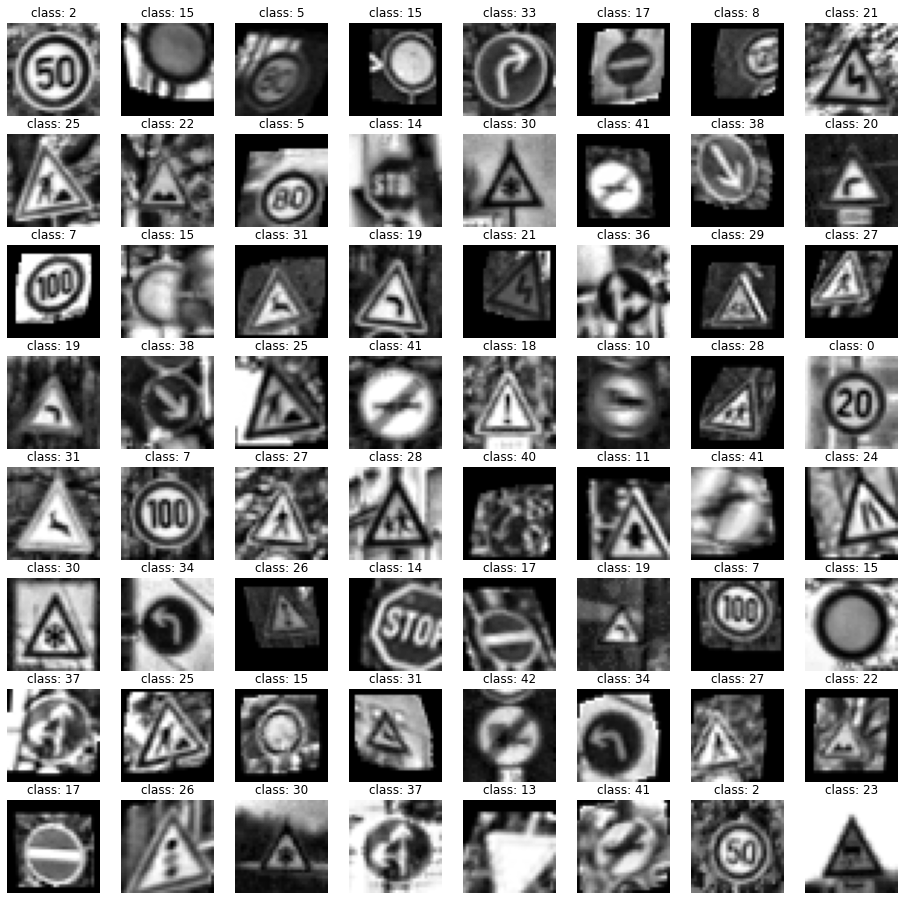

In [ ]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        if i + 1 >= 65:
            break
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

## Train Results after Dataset Improvement

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            wsl_improved_dataset_valid_loss.append(valid_loss)
            wsl_improved_dataset_valid_acc.append(valid_accuracy)
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'Model/model_wsl_2.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [ ]:
n_epochs = 100
model = WSLNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 2.092272	Validation loss: 0.576948	 Validation accruacy: 84.853%
Validation loss decreased (inf --> 0.576948). Saving model...
[Epoch 2/100] Train loss: 1.146289	Validation loss: 0.296908	 Validation accruacy: 91.973%
Validation loss decreased (0.576948 --> 0.296908). Saving model...
[Epoch 3/100] Train loss: 0.786374	Validation loss: 0.194375	 Validation accruacy: 94.830%
Validation loss decreased (0.296908 --> 0.194375). Saving model...
[Epoch 4/100] Train loss: 0.573318	Validation loss: 0.157718	 Validation accruacy: 95.782%
Validation loss decreased (0.194375 --> 0.157718). Saving model...
[Epoch 5/100] Train loss: 0.435846	Validation loss: 0.128858	 Validation accruacy: 96.667%
Validation loss decreased (0.157718 --> 0.128858). Saving model...
[Epoch 6/100] Train loss: 0.349230	Validation loss: 0.129320	 Validation accruacy: 96.916%
[Epoch 7/100] Train loss: 0.283672	Validation loss: 0.101600	 Validation accruacy: 97.256%
Validation loss decreased (0.1288

In [ ]:
check_point = torch.load('Model/model_wsl_2.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.037038	Test accruacy: 98.915%


# WSLNet with STN
Apply Spatial Transformer Networks (STN) to WSLNet

In [ ]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners = True)
        x = F.grid_sample(x, grid, align_corners = True)

        return x

In [ ]:
class WSLNet_STN(nn.Module):
    def __init__(self):
        super(WSLNet_STN, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 120, 5)
        self.conv1_bn = nn.BatchNorm2d(120)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(120, 250, 3)
        self.conv2_bn = nn.BatchNorm2d(250)
        self.conv3 = nn.Conv2d(250, 350, 3)
        self.conv3_bn = nn.BatchNorm2d(350)
        self.conv4 = nn.Conv2d(350, 400, 3)
        self.conv4_bn = nn.BatchNorm2d(400)
        self.fc1 = nn.Linear(4*4*400, 3000)
        self.fc1_bn = nn.BatchNorm1d(3000)
        self.fc2 = nn.Linear(3000, 500)
        self.fc2_bn = nn.BatchNorm1d(500)
        self.fc3 = nn.Linear(500, 50)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x) # STN is added at the front-end of WSLNet
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = F.elu(self.conv2(x))
        x = self.dropout(self.conv2_bn(x))
        x = F.elu(self.conv3(x))
        x = self.dropout(self.conv3_bn(x))
        x = self.pool(F.elu(self.conv4(x)))
        x = self.dropout(self.conv4_bn(x))
        x = x.view(-1, 4*4*400)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = F.elu(self.fc2(x))
        x = self.dropout(self.fc2_bn(x))
        x = self.fc3(x)
        return x

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            wsl_stn_improved_dataset_valid_loss.append(valid_loss)
            wsl_stn_improved_dataset_valid_acc.append(valid_accuracy)
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'Model/model_wsl_stn_1.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

Train and evaluate the model.

In [ ]:
n_epochs = 100
model = WSLNet_STN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 1.783081	Validation loss: 0.437821	 Validation accruacy: 88.617%
Validation loss decreased (inf --> 0.437821). Saving model...
[Epoch 2/100] Train loss: 0.466112	Validation loss: 0.187292	 Validation accruacy: 95.057%
Validation loss decreased (0.437821 --> 0.187292). Saving model...
[Epoch 3/100] Train loss: 0.228594	Validation loss: 0.133286	 Validation accruacy: 96.372%
Validation loss decreased (0.187292 --> 0.133286). Saving model...
[Epoch 4/100] Train loss: 0.139425	Validation loss: 0.122421	 Validation accruacy: 96.735%
Validation loss decreased (0.133286 --> 0.122421). Saving model...
[Epoch 5/100] Train loss: 0.096062	Validation loss: 0.105775	 Validation accruacy: 97.347%
Validation loss decreased (0.122421 --> 0.105775). Saving model...
[Epoch 6/100] Train loss: 0.074127	Validation loss: 0.102695	 Validation accruacy: 97.438%
Validation loss decreased (0.105775 --> 0.102695). Saving model...
[Epoch 7/100] Train loss: 0.056083	Validation loss: 0.113

In [ ]:
check_point = torch.load('Model/model_wsl_stn_1.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.041775	Test accruacy: 98.979%


## STN Results

Visualize the STN results, the geometric invariance of the model is enhanced.

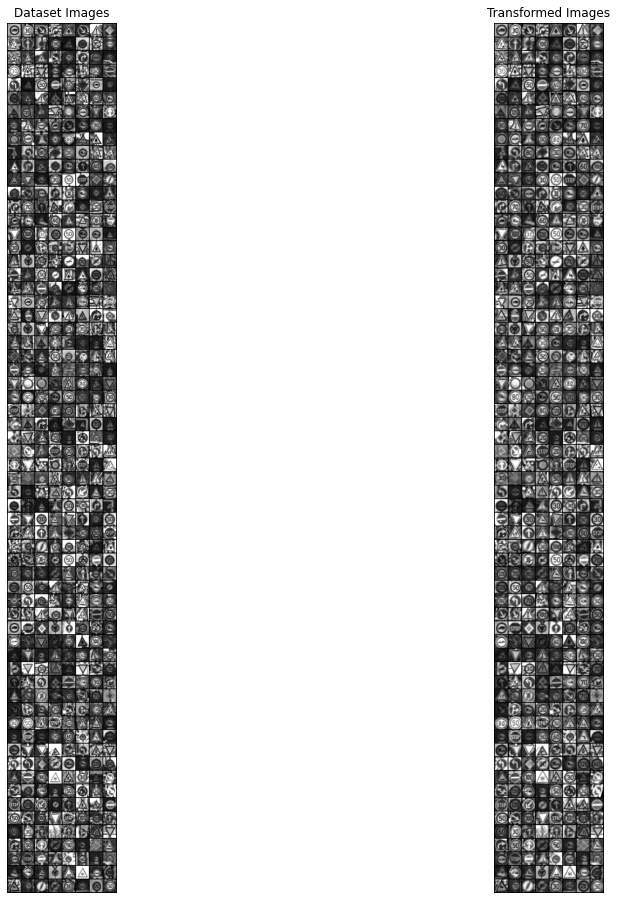

In [ ]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()

# Performance

Compare the loss and accuracy of the WSLNet using  
1) original datasets  
2) extended datasets  
3) extended datasets with STN

Text(0.5, 1.0, 'Valid Accuracy Results')

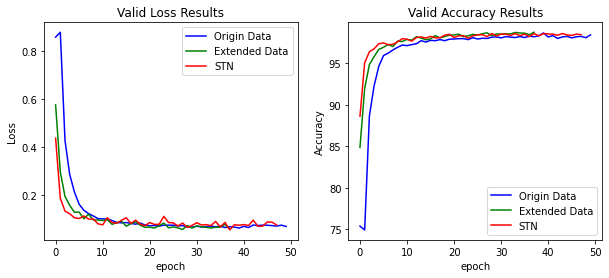

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches((10, 4))
ax[0].plot(wsl_origin_valid_loss, 'b', label='Origin Data')
ax[0].plot(wsl_improved_dataset_valid_loss, 'g', label='Extended Data')
ax[0].plot(wsl_stn_improved_dataset_valid_loss, 'r', label='STN')
ax[0].legend(loc='best')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Valid Loss Results')

ax[1].plot(wsl_origin_valid_acc, 'b', label='Origin Data')
ax[1].plot(wsl_improved_dataset_valid_acc, 'g', label='Extended Data')
ax[1].plot(wsl_stn_improved_dataset_valid_acc, 'r', label='STN')
ax[1].legend(loc='best')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Valid Accuracy Results')

# Prediction

Predict the traffic signs by using the model. The images of the traffic signs are downloaded from the Internet.

In [ ]:
model = WSLNet_STN()
model.load_state_dict(torch.load('Model/model_wsl_stn.pt', map_location=torch.device('cpu')))
model.eval()

WSLNet_STN(
  (stn): Stn(
    (loc_net): Sequential(
      (0): Conv2d(1, 50, kernel_size=(7, 7), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ELU(alpha=1.0)
      (3): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ELU(alpha=1.0)
    )
    (fc_loc): Sequential(
      (0): Linear(in_features=1600, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=100, out_features=6, bias=True)
    )
  )
  (conv1): Conv2d(1, 120, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(120, 250, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv

In [ ]:
def predict(input, model, device):
  model.to(device)
  with torch.no_grad():
    input=input.to(device)
    out = model(input)
    _, pre = torch.max(out.data, 1)
    return pre.item()

In [ ]:
from PIL import Image
def predict_single(model, img_path):
    transform=transforms.Compose(
            [transforms.Grayscale(),
            transforms.Resize((32,32)),
            transforms.ToTensor(),]
        )
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)
    ans = predict(img, model, device)
    return ans

In [ ]:
def plot_prediction(p, img_path):
  img = Image.open(img_path).convert('RGB')
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(img)  
  ax[0].set_title('External Image')
  ax[0].axis('off')
  i = random.choice(np.where(y_train == p)[0])
  ax[1].imshow(X_train[i])
  ax[1].set_title('Dataset Image')
  ax[1].axis('off')

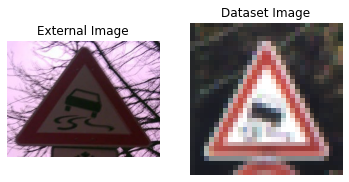

In [ ]:
img_path = "EE5811_repo/examples/1.jpeg"
p = predict_single(model, img_path)
plot_prediction(p, img_path)

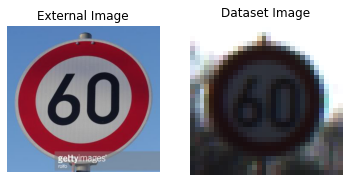

In [ ]:
img_path = "EE5811_repo/examples/2.jpeg"
p = predict_single(model, img_path)
plot_prediction(p, img_path)

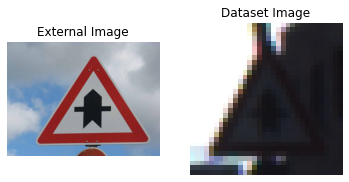

In [ ]:
img_path = "EE5811_repo/examples/3.jpeg"
p = predict_single(model, img_path)
plot_prediction(p, img_path)

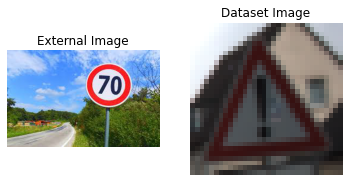

In [ ]:
img_path = "EE5811_repo/examples/4.jpeg"
p = predict_single(model, img_path)
plot_prediction(p, img_path)

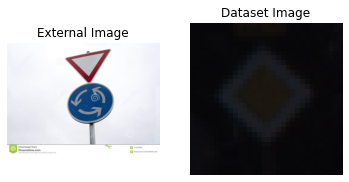

In [ ]:
img_path = "EE5811_repo/examples/5.jpeg"
p = predict_single(model, img_path)
plot_prediction(p, img_path)

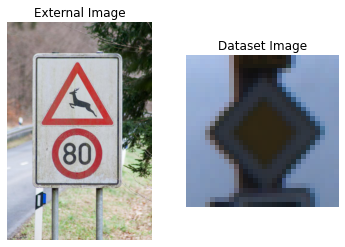

In [ ]:
img_path = "EE5811_repo/examples/6.jpeg"
p = predict_single(model, img_path)
plot_prediction(p, img_path)

If there are multiple traffic signs in a single image, it is hard to classify.

# Traffic Sign Extraction

In some external traffic sign images, the traffic sign may not be the majority of the image. The Sign Extraction function is to extract them, then predict what traffic sign it is through the WSLNet.

In [ ]:
def extract_sign_by_color(original_image):
  boundingbox=[]
  outputlist=[]
  for color in range(3):
    image_hsv=cv2.cvtColor(original_image,cv2.COLOR_BGR2HSV)
    biimage=np.zeros(original_image.shape,np.uint8)
    #extraction color
    if color==0:
      red_low=np.array([0,43,46])
      red_high=np.array([10,255,255])
      red_low2=np.array([156,43,46])
      red_high2=np.array([180,255,255])
      mask=cv2.inRange(image_hsv,lowerb=red_low,upperb=red_high)
      mask2=cv2.inRange(image_hsv,lowerb=red_low2,upperb=red_high2)
      biimage=cv2.bitwise_or(mask,mask2)
    elif color==1:
      blue_low=np.array([100,130,46])
      blue_high=np.array([124,255,255])
      biimage=cv2.inRange(image_hsv,lowerb=blue_low,upperb=blue_high)
    elif color==2:
      yellow_low=np.array([11,43,46])
      yellow_high=np.array([30,255,255])
      biimage=cv2.inRange(image_hsv,lowerb=yellow_low,upperb=yellow_high)
    else:
      return

    #median blur
    biimage=cv2.GaussianBlur(biimage,(3,3),0)

    #开运算
    kernel=np.ones((5,5),np.uint8)
    biimage=cv2.morphologyEx(biimage,cv2.MORPH_OPEN,kernel)

    contours,hierarchy=cv2.findContours(biimage,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

    approxs=[]
    for i in contours:
      arclength=cv2.arcLength(i,True)
      approxs.append(cv2.approxPolyDP(i,0.01*arclength,True))
  
    for i in range(len(contours)):
      contourimage=np.zeros(biimage.shape,np.uint8)
      cv2.drawContours(contourimage,approxs,i,255)
      
      circles = cv2.HoughCircles(contourimage,cv2.HOUGH_GRADIENT,1.5,120,param1=100,param2=50)

      if circles is None:
        if len(approxs[i])>=15:
          continue

      area=cv2.contourArea(contours[i])
      ratio=area/(contourimage.shape[0]*contourimage.shape[1])
      if ratio<=0.01:
        continue

      #获取轮廓外接矩形左上角坐标(x,y)和矩形的宽高
      x,y,w,h=cv2.boundingRect(approxs[i])
      aspect=w/h
      if aspect>=1.5 or aspect<=0.4:
        continue
      
      flag=0
      for j in range(len(boundingbox)):
        if x<=boundingbox[j][0] and x+w>=boundingbox[j][0]+boundingbox[j][2] \
        and y<=boundingbox[j][1] and y+h>=boundingbox[j][1]+boundingbox[j][3]:
          del boundingbox[j]
          del outputlist[j]
          break
        elif x>=boundingbox[j][0] and x+w<=boundingbox[j][0]+boundingbox[j][2] \
        and y>=boundingbox[j][1] and y+h<=boundingbox[j][1]+boundingbox[j][3]:
          flag=1
          break
      if flag:
        continue

      boundingbox.append((x,y,w,h))
      roi=original_image[y-10:y+h+10,x-10:x+w+10]
      outputlist.append(roi)

  return boundingbox,outputlist

In [ ]:
def predict_multi(model, im):
    transform=transforms.Compose(
            [transforms.Grayscale(),
            transforms.Resize((32,32)),
            transforms.ToTensor(),]
        )
    img = Image.fromarray(im)
    img = transform(img)
    img = img.unsqueeze(0)
    ans = predict(img, model, device)
    return ans

In [ ]:
def sign_extract_and_predict(img_path):
  original_image=cv2.imread(img_path)

  boundingbox,signlist=extract_sign_by_color(original_image)

  for img in signlist:
    b = img[:, :, 0].copy()
    g = img[:, :, 1].copy()
    r = img[:, :, 2].copy()
    img[:, :, 0] = r
    img[:, :, 1] = g
    img[:, :, 2] = b
    p = predict_multi(model, img)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img)  
    ax[0].set_title('Extracted Image')
    ax[0].axis('off')
    i = random.choice(np.where(y_train == p)[0])
    ax[1].imshow(X_train[i])
    ax[1].set_title('Dataset Image')
    ax[1].axis('off')
  plt.show()
  plt.clf()
  original_image = plt.imread(img_path)
  for i in boundingbox:
    cv2.rectangle(original_image,(i[0]-10,i[1]-10),(i[0]+i[2]+10,i[1]+i[3]+10),(0,255,0),2)
  plt.title('Original Image')
  plt.axis('off')
  plt.imshow(original_image)

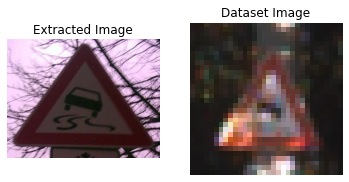

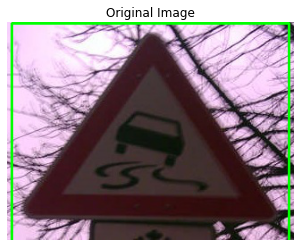

In [ ]:
sign_extract_and_predict("EE5811_repo/examples/1.jpeg")

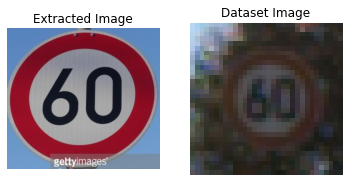

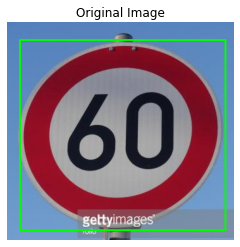

In [ ]:
sign_extract_and_predict("EE5811_repo/examples/2.jpeg")

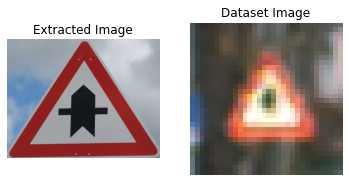

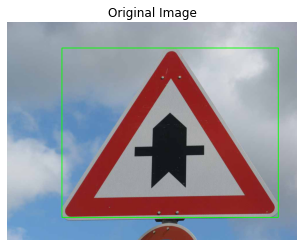

In [ ]:
sign_extract_and_predict("EE5811_repo/examples/3.jpeg")

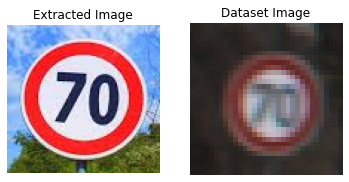

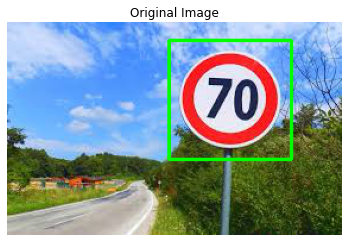

In [ ]:
sign_extract_and_predict("EE5811_repo/examples/4.jpeg")

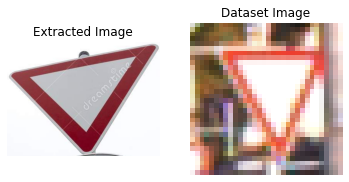

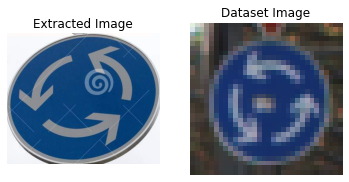

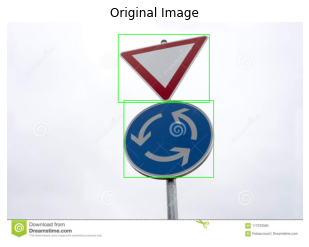

In [ ]:
sign_extract_and_predict("EE5811_repo/examples/5.jpeg")

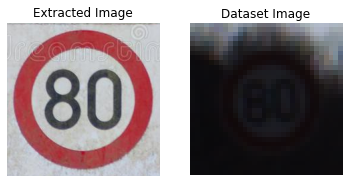

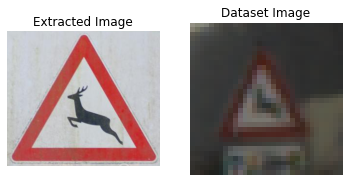

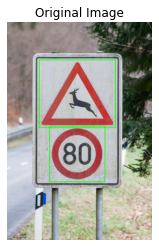

In [ ]:
sign_extract_and_predict("EE5811_repo/examples/6.jpeg")

Multiple traffic signs can be classied well by using Traffic Signs Extraction.